Перемножение матриц размером 100x100


C:\Users\belia\anaconda3\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (49) < 2 * SM count (76) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Корректность: Да
Перемножение матриц размером 500x500
Корректность: Да
Перемножение матриц размером 1000x1000
Корректность: Да
Перемножение матриц размером 1500x1500
Корректность: Да
Перемножение матриц размером 2000x2000
Корректность: Да

Результаты:
Размер    Время CPU (с)  Время GPU (с)  Ускорение 
100       0.27361        0.11200        2.44      
500       0.09900        0.00500        19.79     
1000      0.94200        0.05200        18.12     
1500      4.11200        0.17800        23.10     
2000      13.44100       0.30400        44.21     


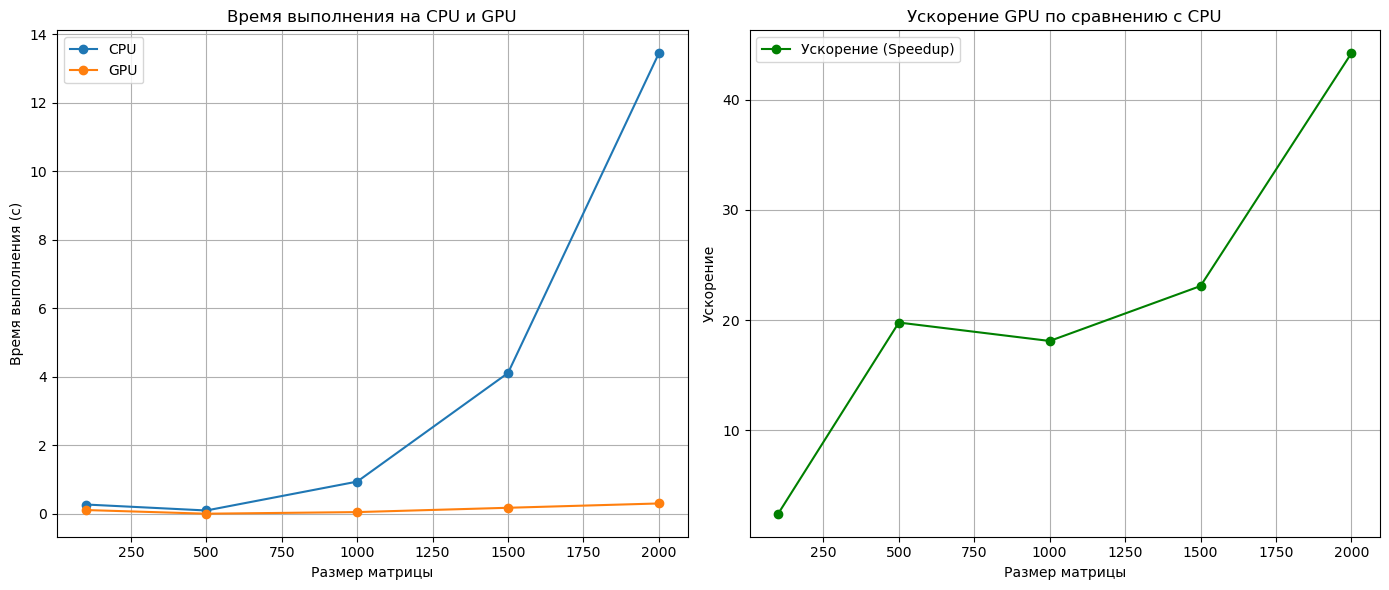

In [6]:
import numpy as np
import time
from numba import jit, cuda
import matplotlib.pyplot as plt

def generate_matrix(size):
    return np.random.rand(size, size).astype(np.float32)

# Перемножение матриц на CPU
@jit(nopython=True, parallel=True)
def matrix_multiply_cpu(A, B):
    size = A.shape[0]
    C = np.zeros((size, size), dtype=np.float32)
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i, j] += A[i, k] * B[k, j]
    return C

# Перемножение матриц на GPU
@cuda.jit
def matrix_multiply_gpu(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.0
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Функция для запуска GPU умножения
def gpu_multiply(A, B):
    size = A.shape[0]
    C = np.zeros((size, size), dtype=np.float32)
    
    # Копируем данные в память GPU
    A_global = cuda.to_device(A)
    B_global = cuda.to_device(B)
    C_global = cuda.to_device(C)
    
    # Настройка сетки и блоков
    threads_per_block = (16, 16)
    blocks_per_grid_x = (size + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (size + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)
    
    # Запуск на GPU
    start_time = time.time()
    matrix_multiply_gpu[blocks_per_grid, threads_per_block](A_global, B_global, C_global)
    cuda.synchronize() 
    end_time = time.time()
    
    return C_global.copy_to_host(), end_time - start_time

# Проверка корректности
def validate_results(C_cpu, C_gpu):
    return np.allclose(C_cpu, C_gpu, atol=1e-6)

def plot_results(sizes, times_cpu, times_gpu, speedups):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(sizes, times_cpu, label="CPU", marker="o")
    plt.plot(sizes, times_gpu, label="GPU", marker="o")
    plt.xlabel("Размер матрицы")
    plt.ylabel("Время выполнения (с)")
    plt.title("Время выполнения на CPU и GPU")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(sizes, speedups, label="Ускорение (Speedup)", marker="o", color="green")
    plt.xlabel("Размер матрицы")
    plt.ylabel("Ускорение")
    plt.title("Ускорение GPU по сравнению с CPU")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    sizes = [100, 500, 1000, 1500, 2000]
    times_cpu = []
    times_gpu = []
    speedups = []

    for size in sizes:
        print(f"Перемножение матриц размером {size}x{size}")
        
        # Генерация матриц
        A = generate_matrix(size)
        B = generate_matrix(size)
        
        # Перемножение на CPU
        start_time = time.time()
        C_cpu = matrix_multiply_cpu(A, B)
        time_cpu = time.time() - start_time
        times_cpu.append(time_cpu)

        # Перемножение на GPU
        C_gpu, time_gpu = gpu_multiply(A, B)
        times_gpu.append(time_gpu)

        # Проверка корректности
        is_valid = validate_results(C_cpu, C_gpu)
        print(f"Корректность: {'Да' if is_valid else 'Нет'}")
        
        # Ускорение
        speedup = time_cpu / time_gpu if time_gpu > 0 else None
        speedups.append(speedup)
    
    print("\nРезультаты:")
    print(f"{'Размер':<10}{'Время CPU (с)':<15}{'Время GPU (с)':<15}{'Ускорение':<10}")
    for size, time_cpu, time_gpu, speedup in zip(sizes, times_cpu, times_gpu, speedups):
        print(f"{size:<10}{time_cpu:<15.5f}{time_gpu:<15.5f}{speedup:<10.2f}")

    # Построение графиков
    plot_results(sizes, times_cpu, times_gpu, speedups)
